In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd

In [2]:
# Fetching data as an array
data = pd.read_csv('pmsm_temperature_data.csv').values

In [3]:
# Seggregating the data according to the profile id

id_indices = []
for i in range(data.shape[0]-1):
    a = data[i,-1]
    b = data[i+1,-1]
    if a != b :
        id_indices.append((a,i))

In [4]:
# Based on the ids, seggregating the features
seg_data = []
start = -1
for i in range(51):
    end = id_indices[i][1]
    id_batch = data[start+1:end+1,:]
    seg_data.append(id_batch)
    start = end
seg_data.append(data[start:,:])
seg_data = np.array(seg_data)

/home/mlai/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [5]:
# preparing data which is compatible with LSTM network

train_x = []
train_y = []
for i in range(seg_data.shape[0]):
    seg = seg_data[i]
    for j in range(0,seg.shape[0]-60,1):
        temp1 = seg[j:j+60,:8]
        temp2 = seg[j:j+60,9:-1]
        temp = np.hstack((temp1,temp2))
        train_x.append(temp)
        train_y.append(seg[j:j+60,:][-1][8])

train_x = np.array(train_x, dtype=np.float16())
train_y = np.array(train_y, dtype=np.float16())

In [6]:
# Splitting the data
# split ratio 70:20:10
num_points = train_x.shape[0]

idx = np.random.permutation(train_x.shape[0])
train_x = train_x[idx]
train_y = train_y[idx]

# Train data
x_train = train_x[0:int(num_points*0.7)]
y_train = train_y[0:int(num_points*0.7)]


# Validation data
x_val = train_x[int(num_points*0.7):int(num_points*0.9)]
y_val = train_y[int(num_points*0.7):int(num_points*0.9)]


# Test data
x_test = train_x[int(num_points*0.9):]
y_test = train_y[int(num_points*0.9):]

In [7]:
print('Training data shape: ', x_train.shape)
print('Training data shape: ', y_train.shape)

Training data shape:  (696465, 60, 11)
Training data shape:  (696465,)


In [8]:
# Importing all the required libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as scheduler
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [9]:
# Checking if GPU is available
cuda = torch.cuda.is_available()
print(cuda)

True


In [10]:

# The following class is used for creating a dataset class using torch functionality. Its a standard pytorch class
class Dataset(data.Dataset):

    def __init__(self, X, Y):

        self.X = X
        self.Y = Y

    def __len__(self):

        return len(self.Y)

    def __getitem__(self,index):

        x_item = torch.from_numpy(self.X[index]).double()
        y_item = torch.from_numpy(np.array(self.Y[index])).double()

        return x_item, y_item

In [11]:
# Creating dataloaders

train_dataset = Dataset(x_train, y_train)            

val_dataset = Dataset(x_val, y_val)              

test_dataset = Dataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1024, shuffle = True)           

dev_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 128)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128)

In [12]:
# Model
class LSTM_Network(nn.Module):
    def __init__(self, in_size, hidden_size, nlayers):
        super(LSTM_Network, self).__init__()
        self.lstm = nn.LSTM(in_size, hidden_size, bidirectional=False, num_layers=nlayers, batch_first = True)
        self.output1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.output2 = nn.Linear(int(hidden_size/2), 1) 
    
    def forward(self, x):
        out,_ = self.lstm(x)
        out = self.output1(out[:,-1,:])
        out = self.output2(out)
        return out

In [13]:

# Defining the device
device = torch.device("cuda" if cuda else "cpu")

# Defining the model
model = LSTM_Network(11,512,3).double()
model.to(device)

# Defining an optimizer
learning_rate = 0.0005
optimizer_adam = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_SGD = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optimizer_adam

# Defining a learning rate scheduler
scheduler_Multistep = scheduler.MultiStepLR(optimizer, milestones = [10, 20, 25, 30], gamma = 0.1)
scheduler_Step = scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)
scheduler = None

# Defining a criterion
criterion = nn.MSELoss()

# Setting training epochs
epochs = 10



In [14]:
# Training function

def train(loader_train, loader_dev, epochs):
    batch_loss = []
    train_loss = []
    train_score = []
    dev_loss = []
    dev_score = []
    counter = 0
    printing = 20
    for epoch in range(epochs):
        counter = 0
        model.train()
        t = time.time()
        print('Training Epoch Number: ', epoch)
        epoch_loss = 0
        epoch_score = 0
        for batch_idx, (data, target) in enumerate(loader_train):

            optimizer.zero_grad()
            data = data.double().to(device)
            target = target.to(device) 
            outputs = model(data)

            loss = criterion(outputs.flatten(), target)
            epoch_loss += loss.item() 
            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

            epoch_score += r2_score(target.detach().cpu().numpy(), outputs.detach().cpu().numpy())
            if counter % printing == 0:
                print("Epoch: {}/{}...".format(epoch+1, epochs),
                    "Step: {}...".format(counter),
                    "Loss: {:.6f}...".format(loss.item()))
            counter += 1
        epoch_loss /= len(loader_train)
        epoch_score /= len(loader_train)

        train_loss.append(epoch_loss)
        train_score.append(epoch_score)

        current_loss, current_score = evaluate(loader_dev)
        print("Validation Loss : ", current_loss)
        dev_loss.append(current_loss)
        dev_score.append(current_score)
        
        print("Epoch time: ", time.time() - t)

        if scheduler != None:
            scheduler.step()
            
        np.savetxt('train_loss.txt', train_loss)
        np.savetxt('train_score.txt', train_score)
        np.savetxt('dev_loss.txt', dev_loss)
        np.savetxt('dev_score.txt', dev_score)
        np.savetxt('batch_loss.txt', batch_loss)
        
        plt.figure(figsize=(8,8))
        plt.plot(train_loss,label='Training loss')
        plt.plot(dev_loss,label='Validation loss')
        plt.legend()
        plt.title('Model loss')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.savefig('loss.png')

        plt.figure(figsize=(8,8))
        plt.plot(train_score,label='Training r2-score')
        plt.plot(dev_score,label='Validation r2-score')
        plt.legend()
        plt.title('Model r2-score')
        plt.xlabel('Epochs')
        plt.ylabel('r2-score')
        plt.savefig('score.png')



    return train_loss, train_score, dev_loss, dev_score, batch_loss

In [15]:
# Evaluation function

def evaluate(loader_dev):

    loss_value = 0
    score_value= 0
    model.eval()

    for batch_idx, (data, target) in enumerate(loader_dev):

        data = data.double().to(device)
        target = target.to(device) 
        outputs = model(data)

        loss = criterion(outputs.flatten(), target)
        loss_value += loss.item()

        score_value += r2_score(target.detach().cpu().numpy(), outputs.detach().cpu().numpy())

    loss_value /= len(loader_dev)
    score_value /= len(loader_dev)

    return loss_value, score_value



Training Epoch Number:  0
Epoch: 1/10... Step: 0... Loss: 1.034725...
Epoch: 1/10... Step: 20... Loss: 0.288292...
Epoch: 1/10... Step: 40... Loss: 0.245260...
Epoch: 1/10... Step: 60... Loss: 0.243286...
Epoch: 1/10... Step: 80... Loss: 0.224876...
Epoch: 1/10... Step: 100... Loss: 0.203594...
Epoch: 1/10... Step: 120... Loss: 0.248677...
Epoch: 1/10... Step: 140... Loss: 0.217813...
Epoch: 1/10... Step: 160... Loss: 0.182364...
Epoch: 1/10... Step: 180... Loss: 0.188928...
Epoch: 1/10... Step: 200... Loss: 0.205122...
Epoch: 1/10... Step: 220... Loss: 0.155172...
Epoch: 1/10... Step: 240... Loss: 0.180933...
Epoch: 1/10... Step: 260... Loss: 0.161201...
Epoch: 1/10... Step: 280... Loss: 0.169562...
Epoch: 1/10... Step: 300... Loss: 0.172302...
Epoch: 1/10... Step: 320... Loss: 0.149317...
Epoch: 1/10... Step: 340... Loss: 0.135850...
Epoch: 1/10... Step: 360... Loss: 0.144634...
Epoch: 1/10... Step: 380... Loss: 0.154400...
Epoch: 1/10... Step: 400... Loss: 0.146172...
Epoch: 1/10...

Epoch: 5/10... Step: 600... Loss: 0.037102...
Epoch: 5/10... Step: 620... Loss: 0.033665...
Epoch: 5/10... Step: 640... Loss: 0.036668...
Epoch: 5/10... Step: 660... Loss: 0.035026...
Epoch: 5/10... Step: 680... Loss: 0.033200...
Validation Loss :  0.03679980592604311
Epoch time:  3176.5824043750763
Training Epoch Number:  5
Epoch: 6/10... Step: 0... Loss: 0.038441...
Epoch: 6/10... Step: 20... Loss: 0.036870...
Epoch: 6/10... Step: 40... Loss: 0.044201...
Epoch: 6/10... Step: 60... Loss: 0.036229...
Epoch: 6/10... Step: 80... Loss: 0.052256...
Epoch: 6/10... Step: 100... Loss: 0.039414...
Epoch: 6/10... Step: 120... Loss: 0.037300...
Epoch: 6/10... Step: 140... Loss: 0.042780...
Epoch: 6/10... Step: 160... Loss: 0.042899...
Epoch: 6/10... Step: 180... Loss: 0.035620...
Epoch: 6/10... Step: 200... Loss: 0.034019...
Epoch: 6/10... Step: 220... Loss: 0.042128...
Epoch: 6/10... Step: 240... Loss: 0.047455...
Epoch: 6/10... Step: 260... Loss: 0.040951...
Epoch: 6/10... Step: 280... Loss: 0

Epoch: 10/10... Step: 460... Loss: 0.038155...
Epoch: 10/10... Step: 480... Loss: 0.026388...
Epoch: 10/10... Step: 500... Loss: 0.022756...
Epoch: 10/10... Step: 520... Loss: 0.026156...
Epoch: 10/10... Step: 540... Loss: 0.020296...
Epoch: 10/10... Step: 560... Loss: 0.015467...
Epoch: 10/10... Step: 580... Loss: 0.032217...
Epoch: 10/10... Step: 600... Loss: 0.022222...
Epoch: 10/10... Step: 620... Loss: 0.098766...
Epoch: 10/10... Step: 640... Loss: 0.056034...
Epoch: 10/10... Step: 660... Loss: 0.052218...
Epoch: 10/10... Step: 680... Loss: 0.041968...
Validation Loss :  0.037363714997155587
Epoch time:  3171.7632880210876


Test loss:  0.03746926165004068
Test r2-score:  0.9606755233438979


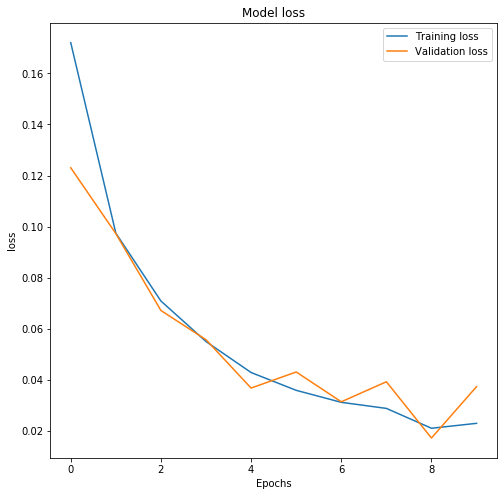

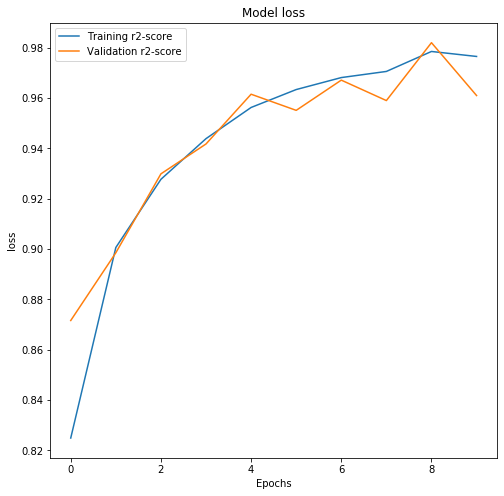

In [16]:


def main():

    train_loss, train_score, dev_loss, dev_score, batch_loss = train(train_loader, dev_loader, epochs)

    test_loss, test_score = evaluate(test_loader)
    
    np.savetxt('train_loss.txt', train_loss)
    np.savetxt('train_score.txt', train_score)
    np.savetxt('dev_loss.txt', dev_loss)
    np.savetxt('dev_score.txt', dev_score)
    np.savetxt('batch_loss.txt', batch_loss)

    print('\n')

    print('Test loss: ', test_loss)
    print('Test r2-score: ', test_score)

    plt.figure(figsize=(8,8))
    plt.plot(train_loss,label='Training loss')
    plt.plot(dev_loss,label='Validation loss')
    plt.legend()
    plt.title('Model loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig('loss.png')

    plt.figure(figsize=(8,8))
    plt.plot(train_score,label='Training r2-score')
    plt.plot(dev_score,label='Validation r2-score')
    plt.legend()
    plt.title('Model loss')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.savefig('score.png')


if __name__ == '__main__':

    main()

In [1]:
train_loss = open("train_loss.txt", "r")
content = train_loss.read()
print(content)

1.719970907794326209e-01
9.743209640011336881e-02
7.087736279767913039e-02
5.501358054894735228e-02
4.288351658943010541e-02
3.591446567359899561e-02
3.122146075317177097e-02
2.884247708698219406e-02
2.107165703811861995e-02
2.299654947623185758e-02



In [2]:
train_loss = open("train_score.txt", "r")
content = train_loss.read()
print(content)

8.249024889750253831e-01
9.006174537926513457e-01
9.277182392026126490e-01
9.438791830111891157e-01
9.562676230230675589e-01
9.633843300781924635e-01
9.681447658049433524e-01
9.705847833483826070e-01
9.785193407295542656e-01
9.765401108693354537e-01



In [3]:
train_loss = open("dev_loss.txt", "r")
content = train_loss.read()
print(content)

1.230427790556424261e-01
9.727162768177079200e-02
6.716631115086391102e-02
5.572840397734333401e-02
3.679980592604310818e-02
4.309923486651168201e-02
3.143380290943233873e-02
3.926491490498511261e-02
1.724243393916891076e-02
3.736371499715558653e-02



In [5]:
train_loss = open("dev_score.txt", "r")
content = train_loss.read()
print(content)

8.716047773076195382e-01
8.985272008789921827e-01
9.298863591747934532e-01
9.417668428185429486e-01
9.615323247756536462e-01
9.551204761723606218e-01
9.671302161028257904e-01
9.590072557386570828e-01
9.820104393146713573e-01
9.610112390102870661e-01

